# Inspect the single-lineage model run on the colorectal data (005)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-colorectal-005_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-colorectal-005'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-colorectal-005",
    "description": " Single lineage hierarchical negative binomial model for colorectal data from the Broad. The number of cancer genes has been limited by having to be mutated in at least 25% of cell lines. I have also increased the number of tuning steps from 1,000 to 2,000 and increased the target acceptance probability to 0.99. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_colorectal.csv",
    "model_kwargs": {
        "lineage": "colorectal",
        "min_frac_cancer_genes": 0.2
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 2000,
            "chains": 4,
           

### Load posterior summary

In [7]:
crc_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
crc_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a  0.119  0.001     0.118      0.121        0.0      0.0    2583.0   
1      mu_b -0.001  0.000    -0.001     -0.000        0.0      0.0    4301.0   
2      mu_d -0.022  0.000    -0.023     -0.022        0.0      0.0    4271.0   
3   sigma_a  0.182  0.001     0.181      0.183        0.0      0.0    1168.0   
4     alpha  7.858  0.007     7.848      7.870        0.0      0.0    3100.0   

   ess_tail  r_hat var_name  
0    2932.0    1.0  mu_mu_a  
1    3589.0    1.0     mu_b  
2    3631.0    1.0     mu_d  
3    2194.0    1.0  sigma_a  
4    2713.0    1.0    alpha

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Colorectal data

In [9]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


crc_dm = CrisprScreenDataManager(
    modeling_data_dir()
    / "lineage-modeling-data"
    / "depmap-modeling-data_colorectal.csv",
    transformations=[_broad_only],
)

In [10]:
crc_data = crc_dm.get_data(read_kwargs={"low_memory": False})
crc_data.head()

sgrna                  replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  LS513-311Cas9_RepA_p6_batch2  0.594321           2   
1  AAATCAGAGAAACCTGAACG  LS513-311Cas9_RepA_p6_batch2 -0.363633           2   
2  AACGTCTTTGAAGAAAGCTG  LS513-311Cas9_RepA_p6_batch2 -0.001343           2   
3  AACGTCTTTGAAGGAAGCTG  LS513-311Cas9_RepA_p6_batch2  0.367220           2   
4  AAGAGGTTCCAGACTACTTA  LS513-311Cas9_RepA_p6_batch2 -1.180029           2   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number     lineage  \
0                 NaN       False     0.951337  colorectal   
1                 NaN       False     0.945508  colorectal   
2                 NaN       False     1.428663  colorectal   
3                 NaN       False     1.428663  colorectal   
4                 NaN       False     0.466222  colorectal   

             lineage_subtype primary_or_metastasis  is_male   age  
0  colorectal_adenocarcinoma               primary     True  63.0  
1  colorectal_adenocarcinoma               primary     True  63.0  
2  colorectal_adenocarcinoma               primary     True  63.0  
3  colorectal_adenocarcinoma               primary     True  63.0  
4  colorectal_adenocarcinoma               primary     True  63.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
crc_model = LineageHierNegBinomModel(lineage="colorectal", min_frac_cancer_genes=0.2)

In [12]:
valid_crc_data = crc_model.data_processing_pipeline(crc_data.copy())
crc_model_data = crc_model.make_data_structure(valid_crc_data)

[INFO] 2022-08-03 06:59:50 [(lineage_hierarchical_nb.py:data_processing_pipeline:274] Processing data for modeling.
[INFO] 2022-08-03 06:59:50 [(lineage_hierarchical_nb.py:data_processing_pipeline:275] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-03 07:01:33 [(lineage_hierarchical_nb.py:data_processing_pipeline:326] number of data points dropped: 25
[INFO] 2022-08-03 07:01:36 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:493] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-03 07:01:36 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:496] Genes always mutated: 
[INFO] 2022-08-03 07:01:39 [(lineage_hierarchical_nb.py:_trim_cancer_genes:549] Dropping 21 cancer genes.
[DEBUG] 2022-08-03 07:01:39 [(lineage_hierarchical_nb.py:_trim_cancer_genes:550] Dropped cancer genes: ['AKT1', 'AXIN1', 'BAX', 'ERBB3', 'GRIN2A', 'HIF1A', 'MAP2K1', 'MAX', 'MDM2', 'MLH1', 'MSH2', 'PIK3R1', 'POLE', 'PTPRT', 'SALL4', 'SFRP4', 'SMAD2', 'SMAD3', 'SMAD4', 'SRC', 'TGFBR2']


In [13]:
crc_model_data.coords["cancer_gene"]

['APC', 'AXIN2', 'B2M', 'FBXW7', 'KRAS', 'MSH6', 'PIK3CA', 'POLD1', 'UBR5']

## Analysis

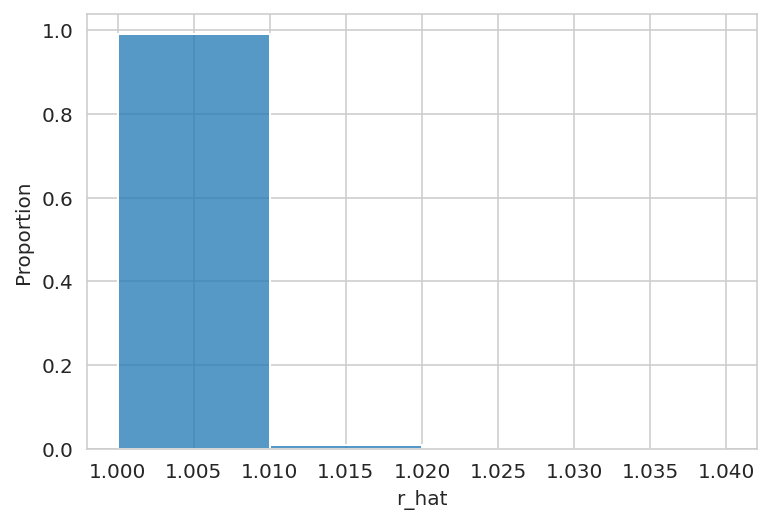

In [14]:
sns.histplot(x=crc_post_summary["r_hat"], binwidth=0.01, stat="proportion");

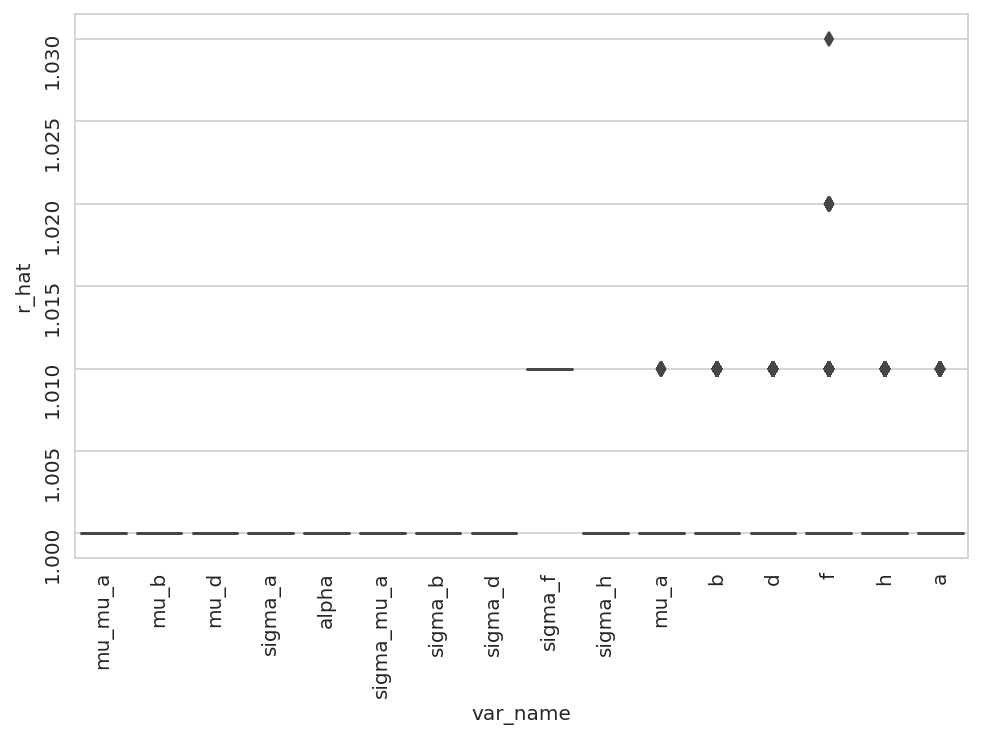

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=crc_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

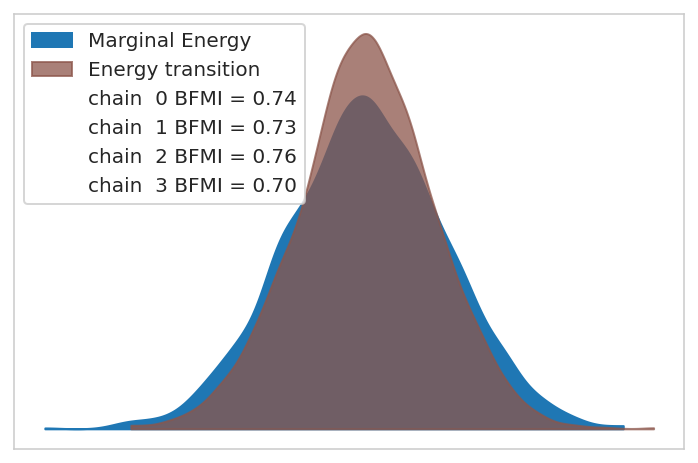

In [16]:
az.plot_energy(trace);

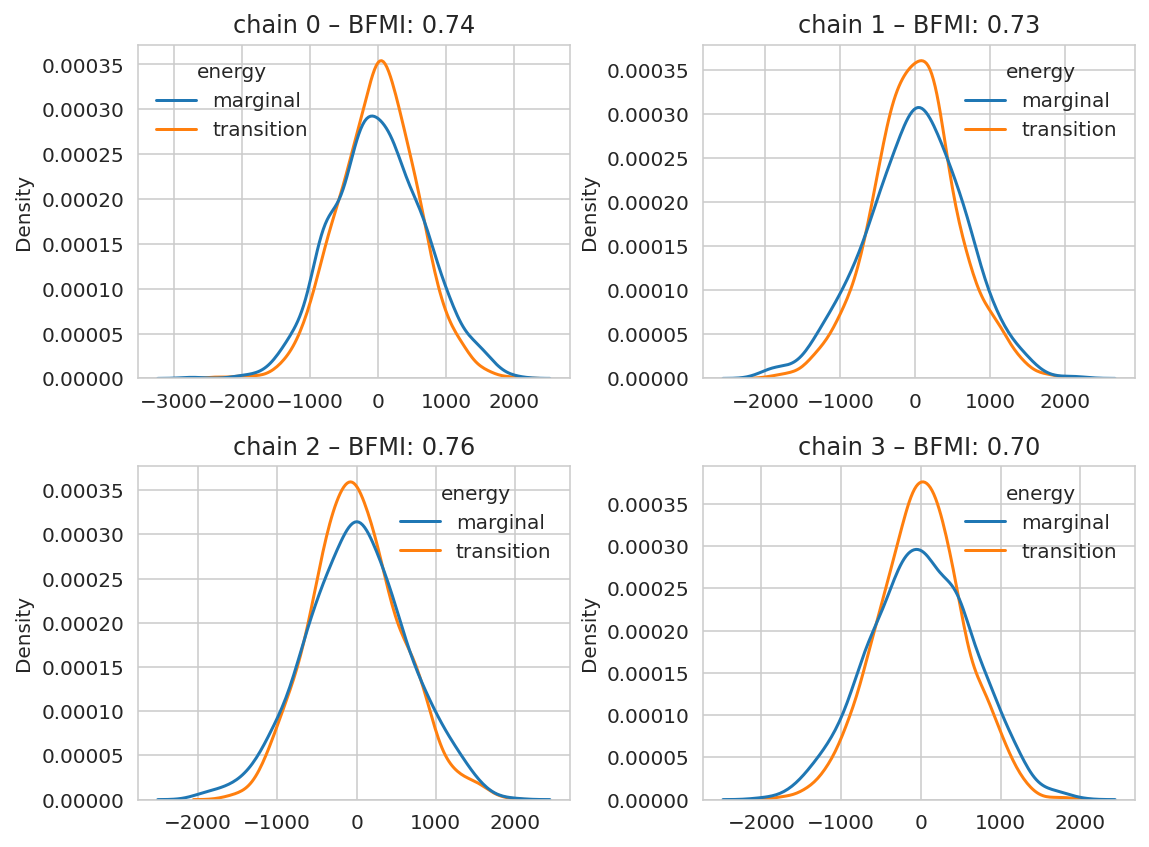

In [17]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

In [18]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                               
0       0.008668    511.0         9.0         0.988654  1.912181e+07
1       0.010030    511.0         9.0         0.985516  1.912168e+07
2       0.009039    511.0         9.0         0.987882  1.912167e+07
3       0.010094    511.0         9.0         0.984214  1.912171e+07

In [19]:
# HAPPY_CHAINS = [0, 1, 2]
# SAD_CHAINS = [3]
# trace.posterior = trace.posterior.sel({"chain": HAPPY_CHAINS})
# trace.posterior_predictive = trace.posterior_predictive.sel({"chain": HAPPY_CHAINS})

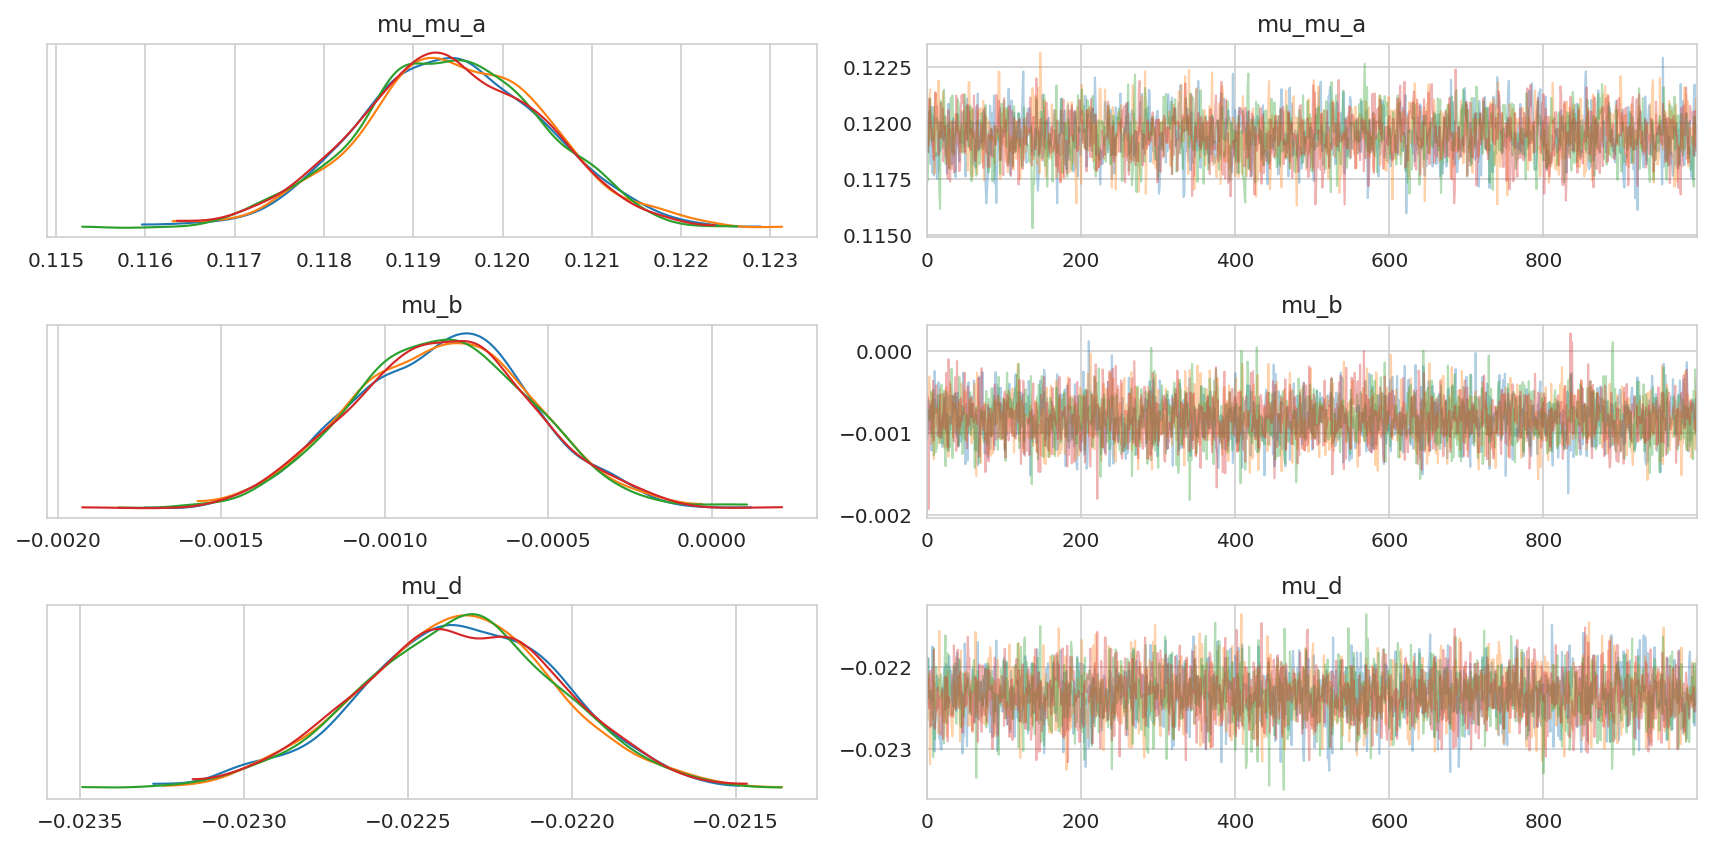

In [20]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
plt.tight_layout()

In [21]:
az.summary(trace, var_names=["mu_mu_a", "mu_b", "mu_d"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu_mu_a  0.119  0.001     0.118      0.121        0.0      0.0    2583.0   
mu_b    -0.001  0.000    -0.001     -0.000        0.0      0.0    4301.0   
mu_d    -0.022  0.000    -0.023     -0.022        0.0      0.0    4271.0   

         ess_tail  r_hat  
mu_mu_a    2932.0    1.0  
mu_b       3589.0    1.0  
mu_d       3631.0    1.0

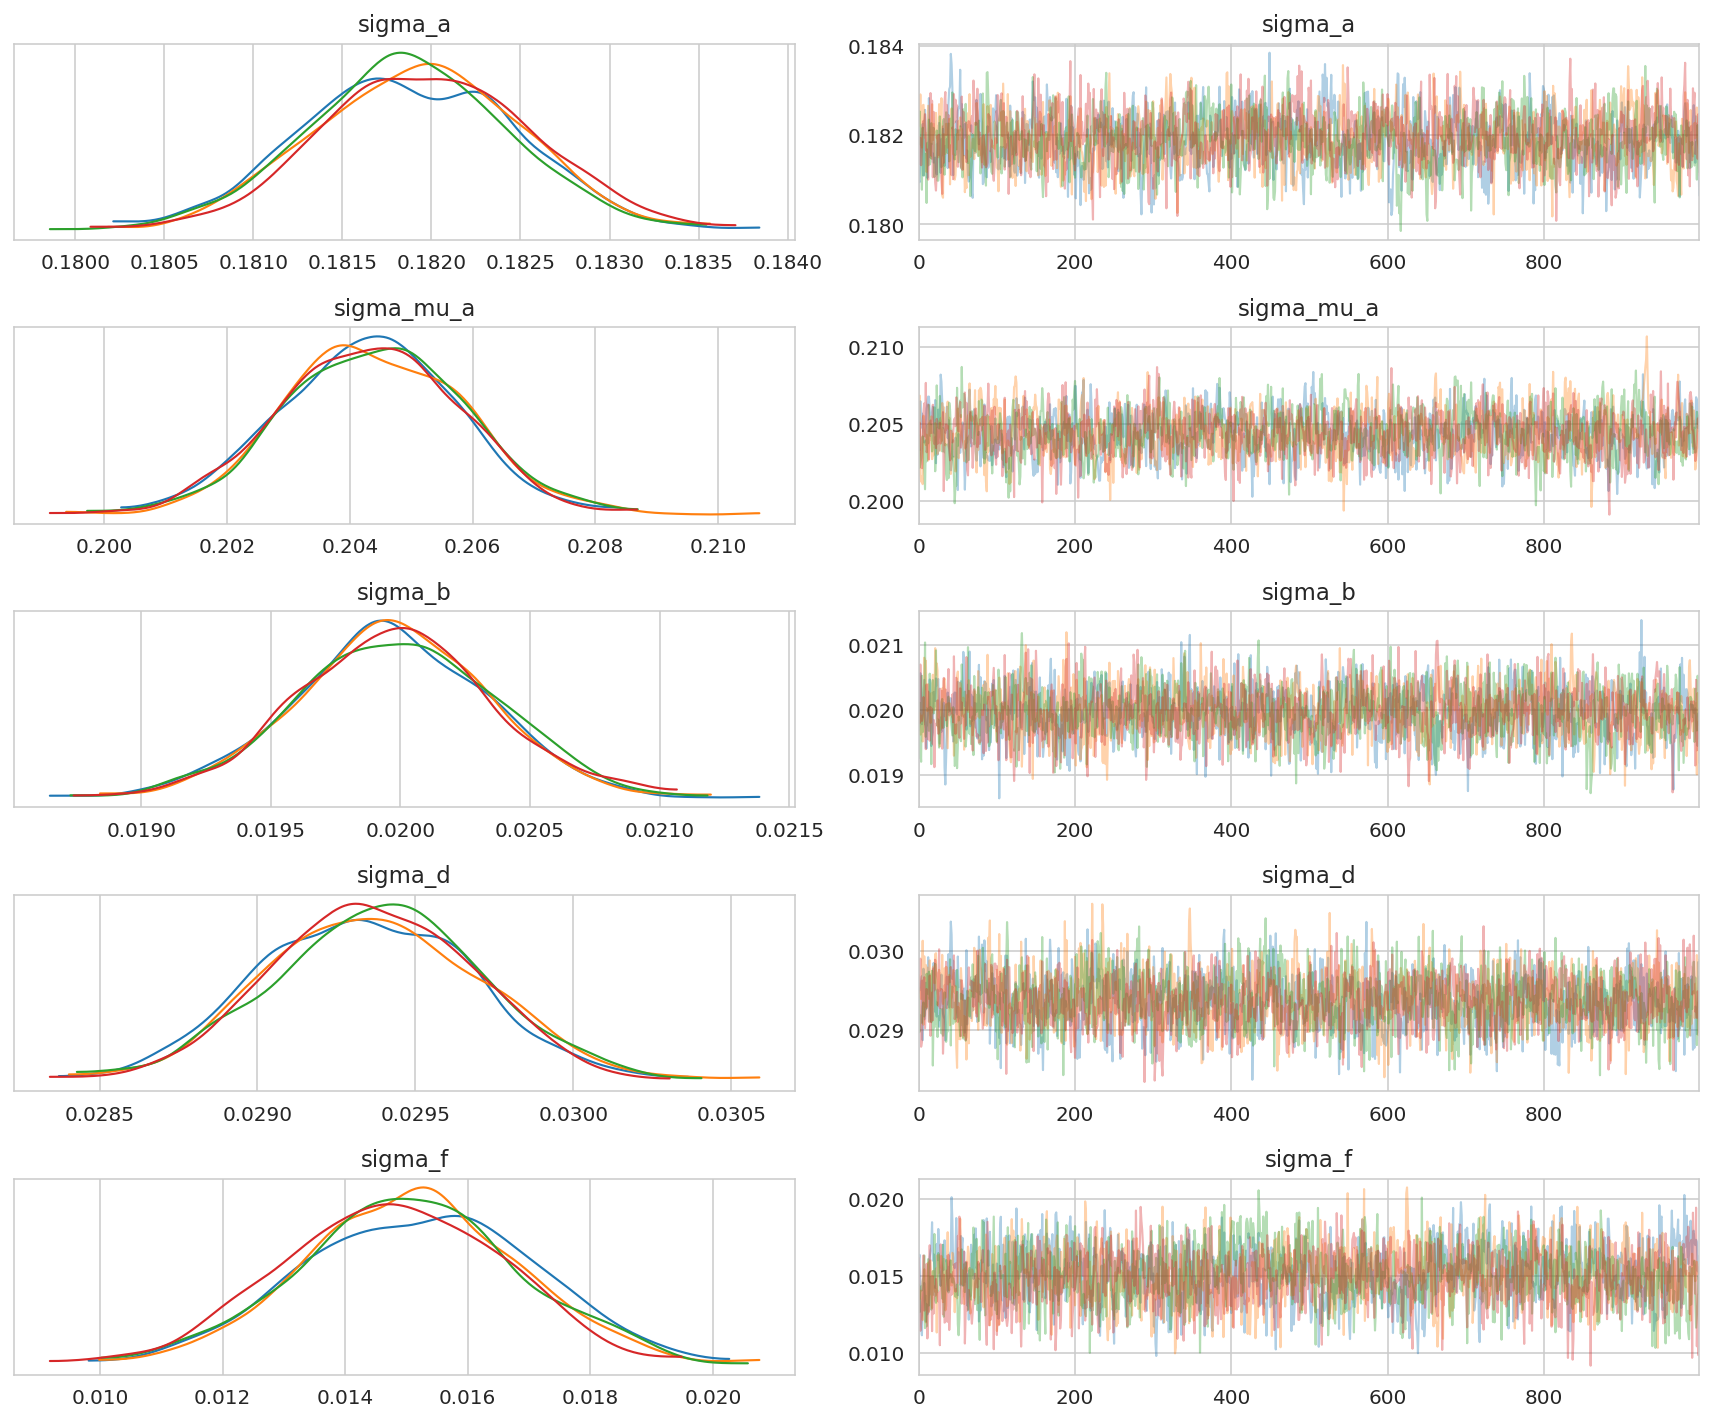

In [22]:
az.plot_trace(
    trace, var_names=[f"sigma_{x}" for x in ["a", "mu_a", "b", "d", "f"]], compact=False
)
plt.tight_layout()
plt.show()

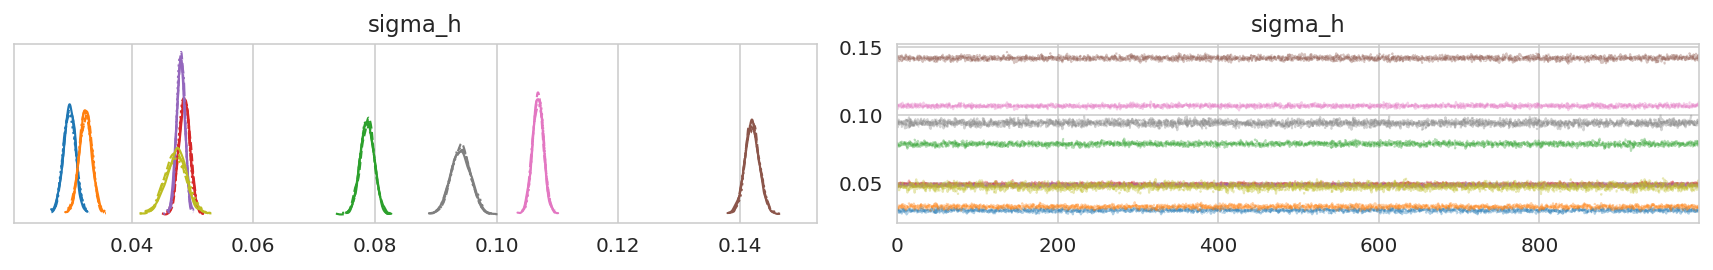

In [23]:
az.plot_trace(trace, var_names=["sigma_h"], compact=True)
plt.tight_layout()
plt.show()

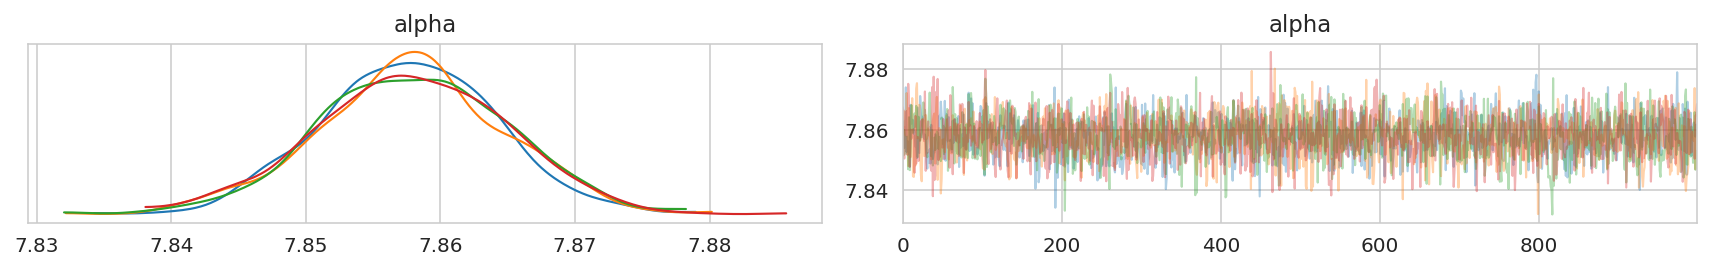

In [24]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()
plt.show()

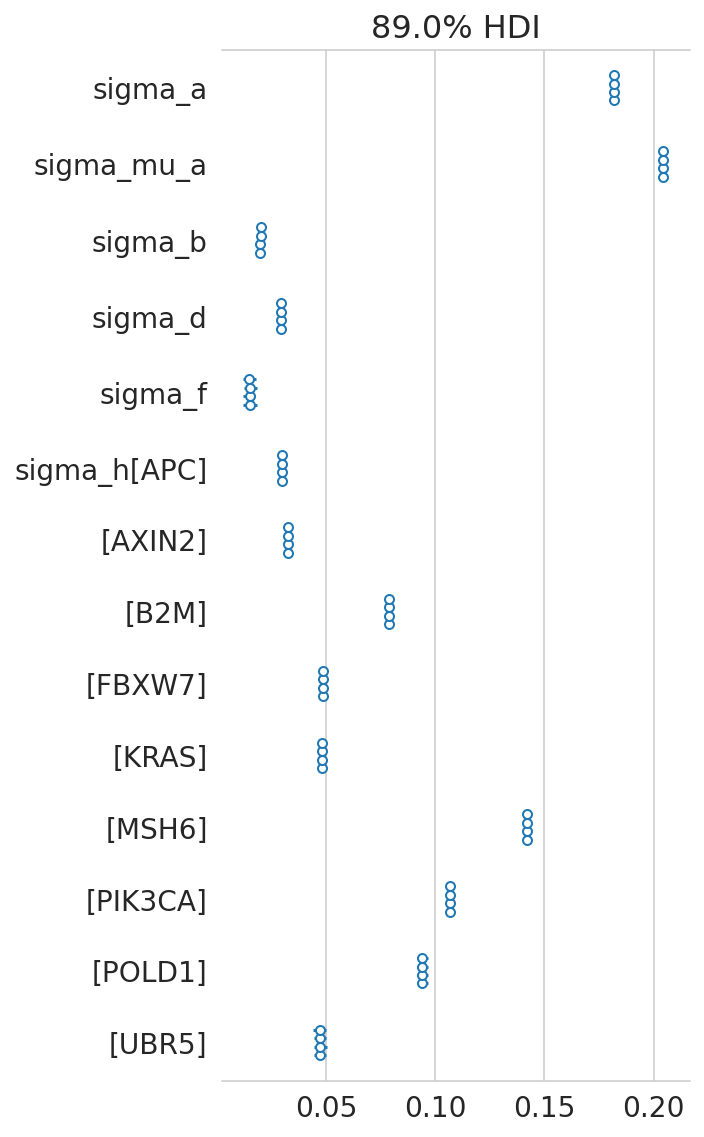

In [25]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 8)
)
plt.tight_layout()

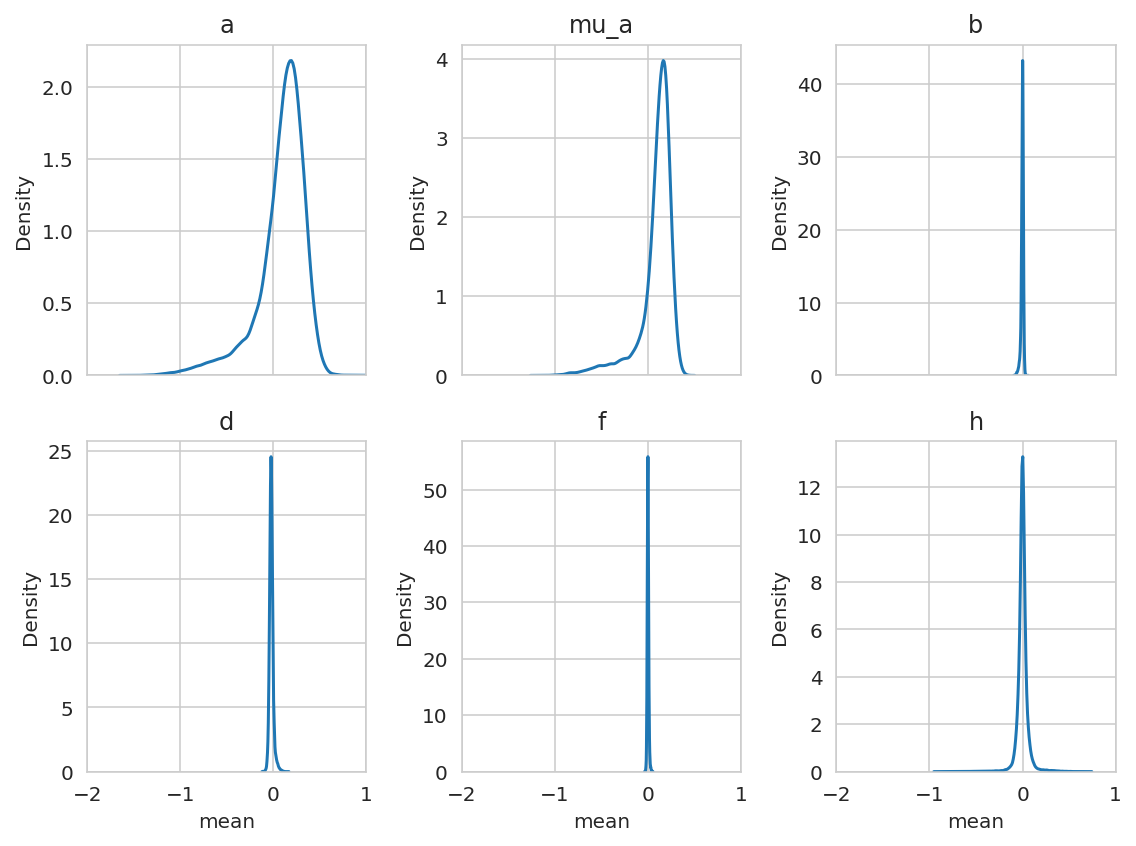

In [26]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = crc_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [27]:
sgrna_to_gene_map = (
    crc_data.copy()[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)

In [28]:
crc_post_summary.query("var_name == 'mu_a'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
12660     mu_a[RAN] -1.183  0.075    -1.304     -1.061      0.001    0.001   
12332   mu_a[PSMD7] -1.062  0.077    -1.187     -0.943      0.001    0.001   
7792    mu_a[KIF11] -1.023  0.074    -1.147     -0.913      0.002    0.001   
11849  mu_a[POLR2L] -1.020  0.074    -1.143     -0.904      0.001    0.001   
13322    mu_a[RPSA] -1.006  0.075    -1.135     -0.893      0.002    0.001   
13177   mu_a[ROCK2]  0.389  0.074     0.275      0.510      0.001    0.001   
16407   mu_a[TRIQK]  0.394  0.073     0.280      0.512      0.001    0.001   
10472    mu_a[OFD1]  0.400  0.071     0.295      0.519      0.001    0.001   
17905  mu_a[ZNF611]  0.413  0.072     0.304      0.529      0.001    0.001   
8819    mu_a[MAPK9]  0.423  0.083     0.283      0.549      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
12660    2563.0    2617.0    1.0     mu_a  
12332    2712.0    2935.0    1.0     mu_a  
7792     2302.0    2828.0    1.0     mu_a  
11849    2806.0    2531.0    1.0     mu_a  
13322    2512.0    2916.0    1.0     mu_a  
13177    2718.0    2902.0    1.0     mu_a  
16407    2724.0    2752.0    1.0     mu_a  
10472    2491.0    3037.0    1.0     mu_a  
17905    2441.0    2944.0    1.0     mu_a  
8819     2879.0    2834.0    1.0     mu_a

In [29]:
crc_post_summary.query("var_name == 'b'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
31284   b[RNGTT] -0.090  0.015    -0.115     -0.066        0.0      0.0   
18806  b[ANKLE2] -0.090  0.015    -0.112     -0.064        0.0      0.0   
30419   b[PSMA6] -0.084  0.016    -0.109     -0.056        0.0      0.0   
30883   b[RBM22] -0.084  0.016    -0.107     -0.057        0.0      0.0   
30451   b[PSMD7] -0.082  0.017    -0.107     -0.055        0.0      0.0   
24038    b[GET4]  0.034  0.015     0.011      0.059        0.0      0.0   
33183   b[STON1]  0.035  0.014     0.012      0.056        0.0      0.0   
18748  b[AMIGO2]  0.035  0.014     0.015      0.059        0.0      0.0   
20819  b[CDKN1C]  0.045  0.015     0.021      0.068        0.0      0.0   
20817  b[CDKN1A]  0.057  0.015     0.032      0.080        0.0      0.0   

       ess_bulk  ess_tail  r_hat var_name  
31284    8053.0    2945.0    1.0        b  
18806    9072.0    2635.0    1.0        b  
30419    8557.0    2802.0    1.0        b  
30883    7176.0    2830.0    1.0        b  
30451    8109.0    3167.0    1.0        b  
24038    8017.0    2648.0    1.0        b  
33183   10819.0    3014.0    1.0        b  
18748    9299.0    2655.0    1.0        b  
20819    7445.0    2837.0    1.0        b  
20817    8310.0    2461.0    1.0        b

In [30]:
crc_post_summary.query("var_name == 'd'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
50218    d[SIK3] -0.113  0.021    -0.147     -0.080        0.0      0.0   
38694   d[CCND1] -0.112  0.020    -0.143     -0.077        0.0      0.0   
41087   d[ERBB2] -0.110  0.023    -0.147     -0.073        0.0      0.0   
48547   d[PSMB5] -0.104  0.021    -0.142     -0.073        0.0      0.0   
50106    d[SGK1] -0.093  0.022    -0.132     -0.061        0.0      0.0   
43071  d[HNRNPK]  0.115  0.021     0.080      0.147        0.0      0.0   
48080  d[POLR2D]  0.116  0.020     0.086      0.151        0.0      0.0   
39248   d[CIAO3]  0.118  0.020     0.086      0.149        0.0      0.0   
42214   d[GINS2]  0.129  0.021     0.094      0.159        0.0      0.0   
47943    d[PLK1]  0.160  0.021     0.125      0.190        0.0      0.0   

       ess_bulk  ess_tail  r_hat var_name  
50218    9276.0    2842.0    1.0        d  
38694   10973.0    2728.0    1.0        d  
41087    8812.0    2709.0    1.0        d  
48547    6334.0    3126.0    1.0        d  
50106   10640.0    2608.0    1.0        d  
43071   10445.0    2433.0    1.0        d  
48080    8419.0    2863.0    1.0        d  
39248    7065.0    3107.0    1.0        d  
42214    9683.0    2769.0    1.0        d  
47943   10820.0    2655.0    1.0        d

In [31]:
crc_post_summary.query("var_name == 'h'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
186277       h[RAN, MSH6] -0.935  0.052    -1.019     -0.852      0.001   
111172    h[DONSON, MSH6] -0.855  0.053    -0.944     -0.772      0.001   
192235      h[RPSA, MSH6] -0.846  0.054    -0.938     -0.765      0.001   
183325     h[PSMD7, MSH6] -0.838  0.054    -0.921     -0.751      0.001   
178978    h[POLR2L, MSH6] -0.833  0.053    -0.915     -0.745      0.001   
111173  h[DONSON, PIK3CA]  0.624  0.045     0.556      0.700      0.001   
192236    h[RPSA, PIK3CA]  0.624  0.045     0.559      0.700      0.001   
183326   h[PSMD7, PIK3CA]  0.627  0.045     0.554      0.697      0.001   
178979  h[POLR2L, PIK3CA]  0.631  0.044     0.563      0.704      0.001   
186278     h[RAN, PIK3CA]  0.727  0.045     0.655      0.798      0.001   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name  
186277    0.001    2690.0    2749.0    1.0        h  
111172    0.001    2946.0    3117.0    1.0        h  
192235    0.001    2618.0    2965.0    1.0        h  
183325    0.001    2952.0    3137.0    1.0        h  
178978    0.001    2937.0    2991.0    1.0        h  
111173    0.001    3509.0    3278.0    1.0        h  
192236    0.001    3784.0    3236.0    1.0        h  
183326    0.001    3773.0    3040.0    1.0        h  
178979    0.000    3964.0    3424.0    1.0        h  
186278    0.001    3450.0    3049.0    1.0        h

In [32]:
def _md_bold(s: str) -> None:
    display(Markdown(f"**{s}**"))

**KRAS**

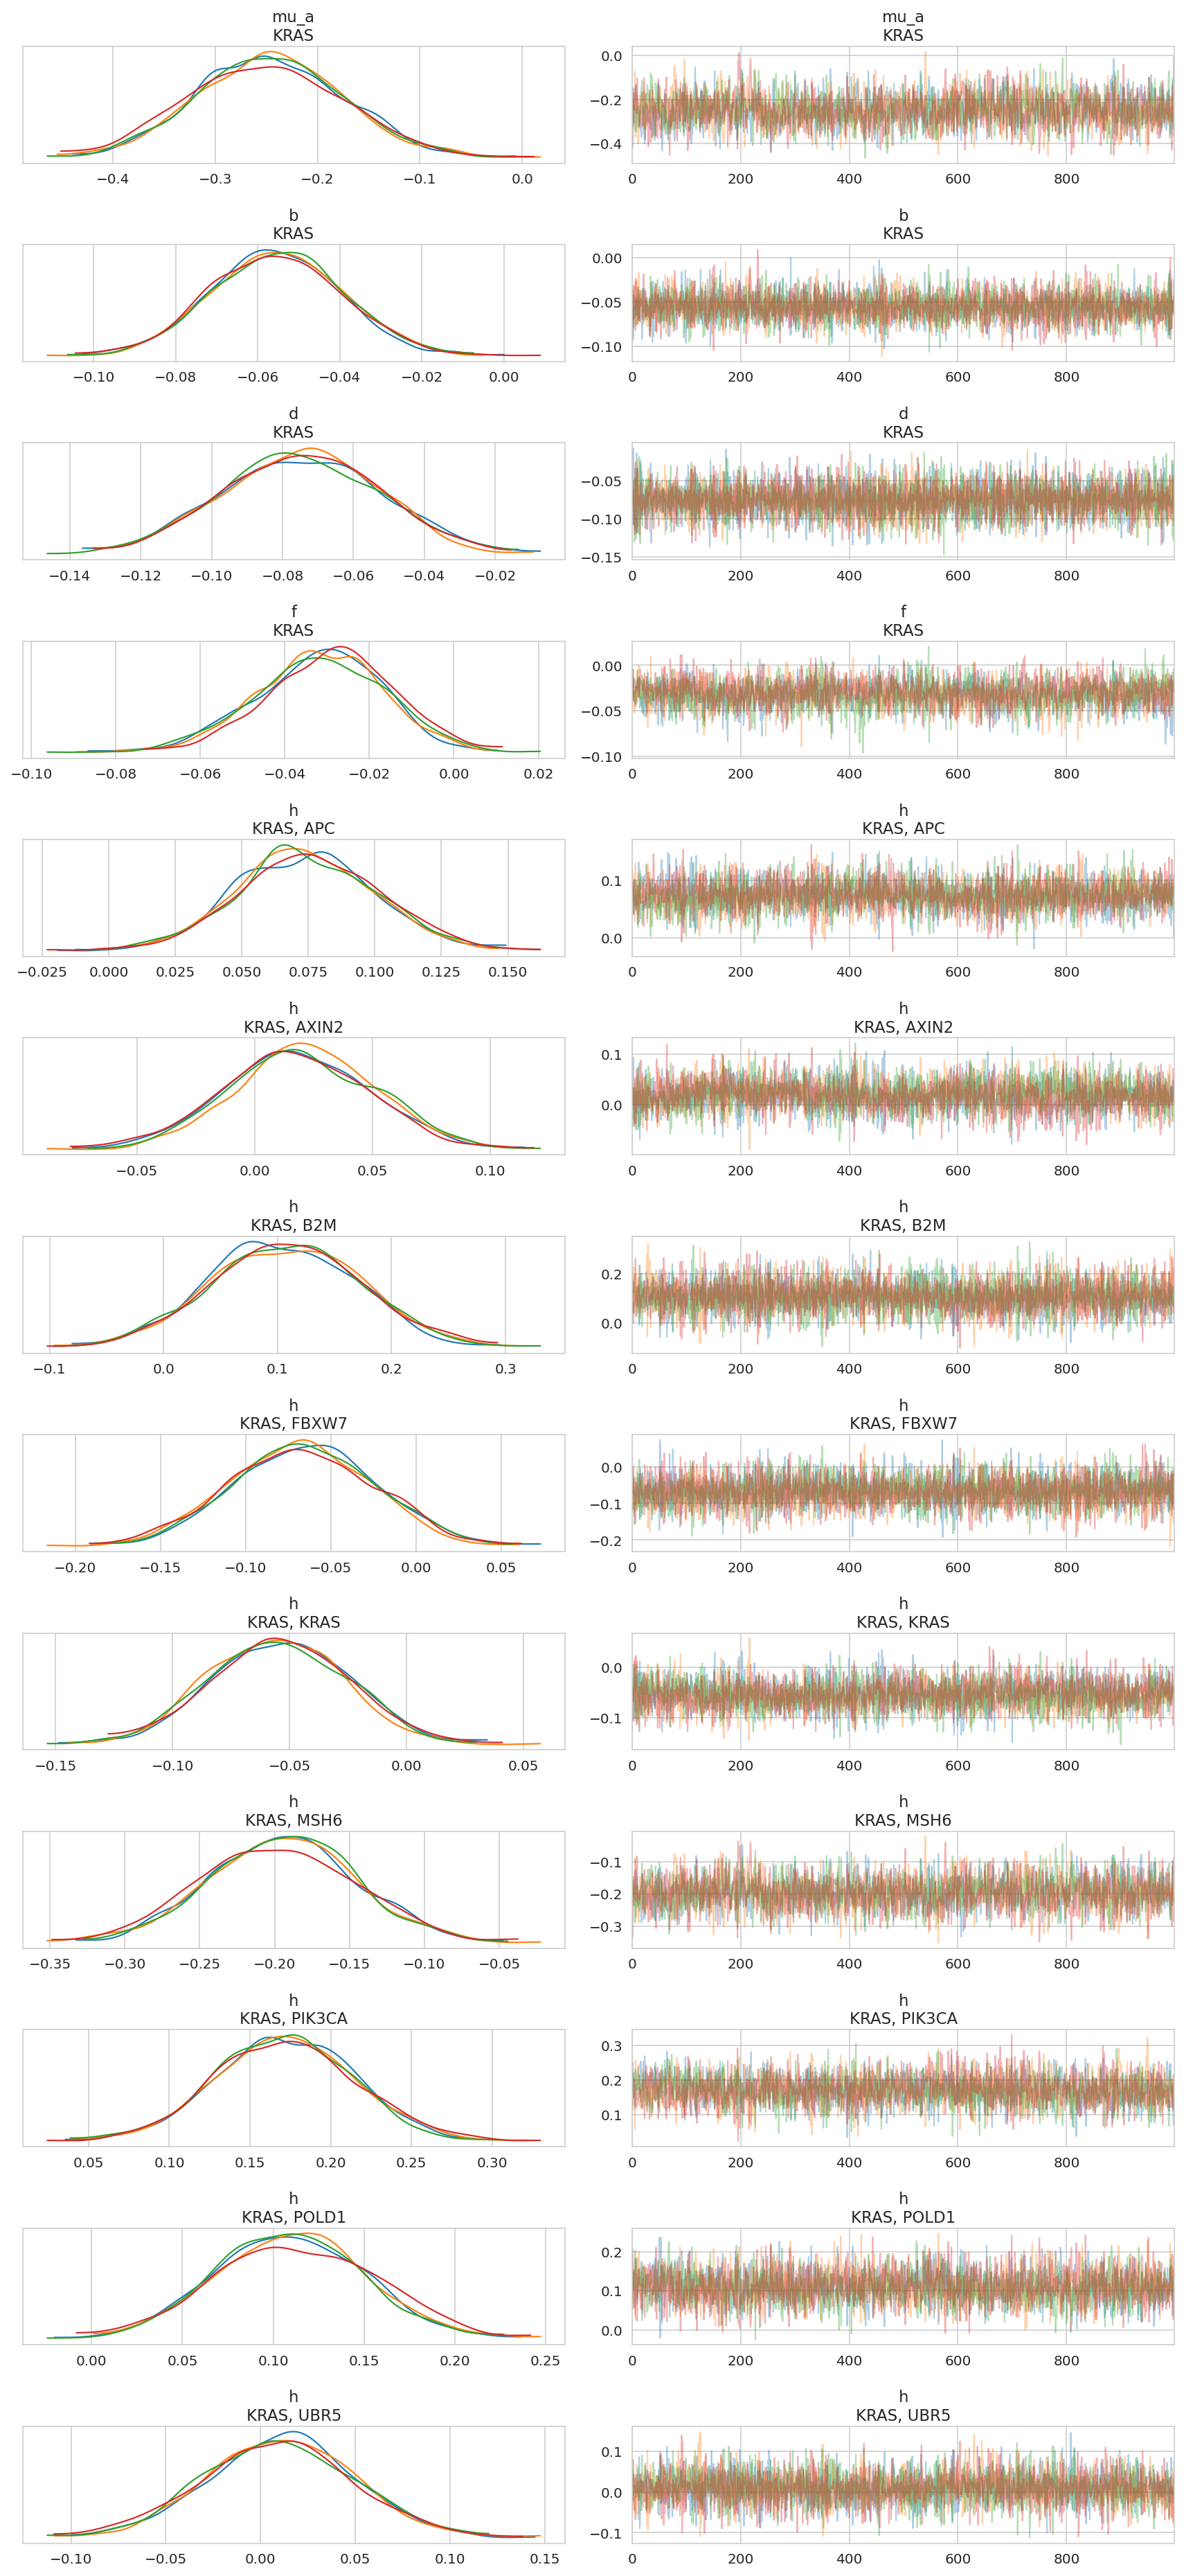

**APC**

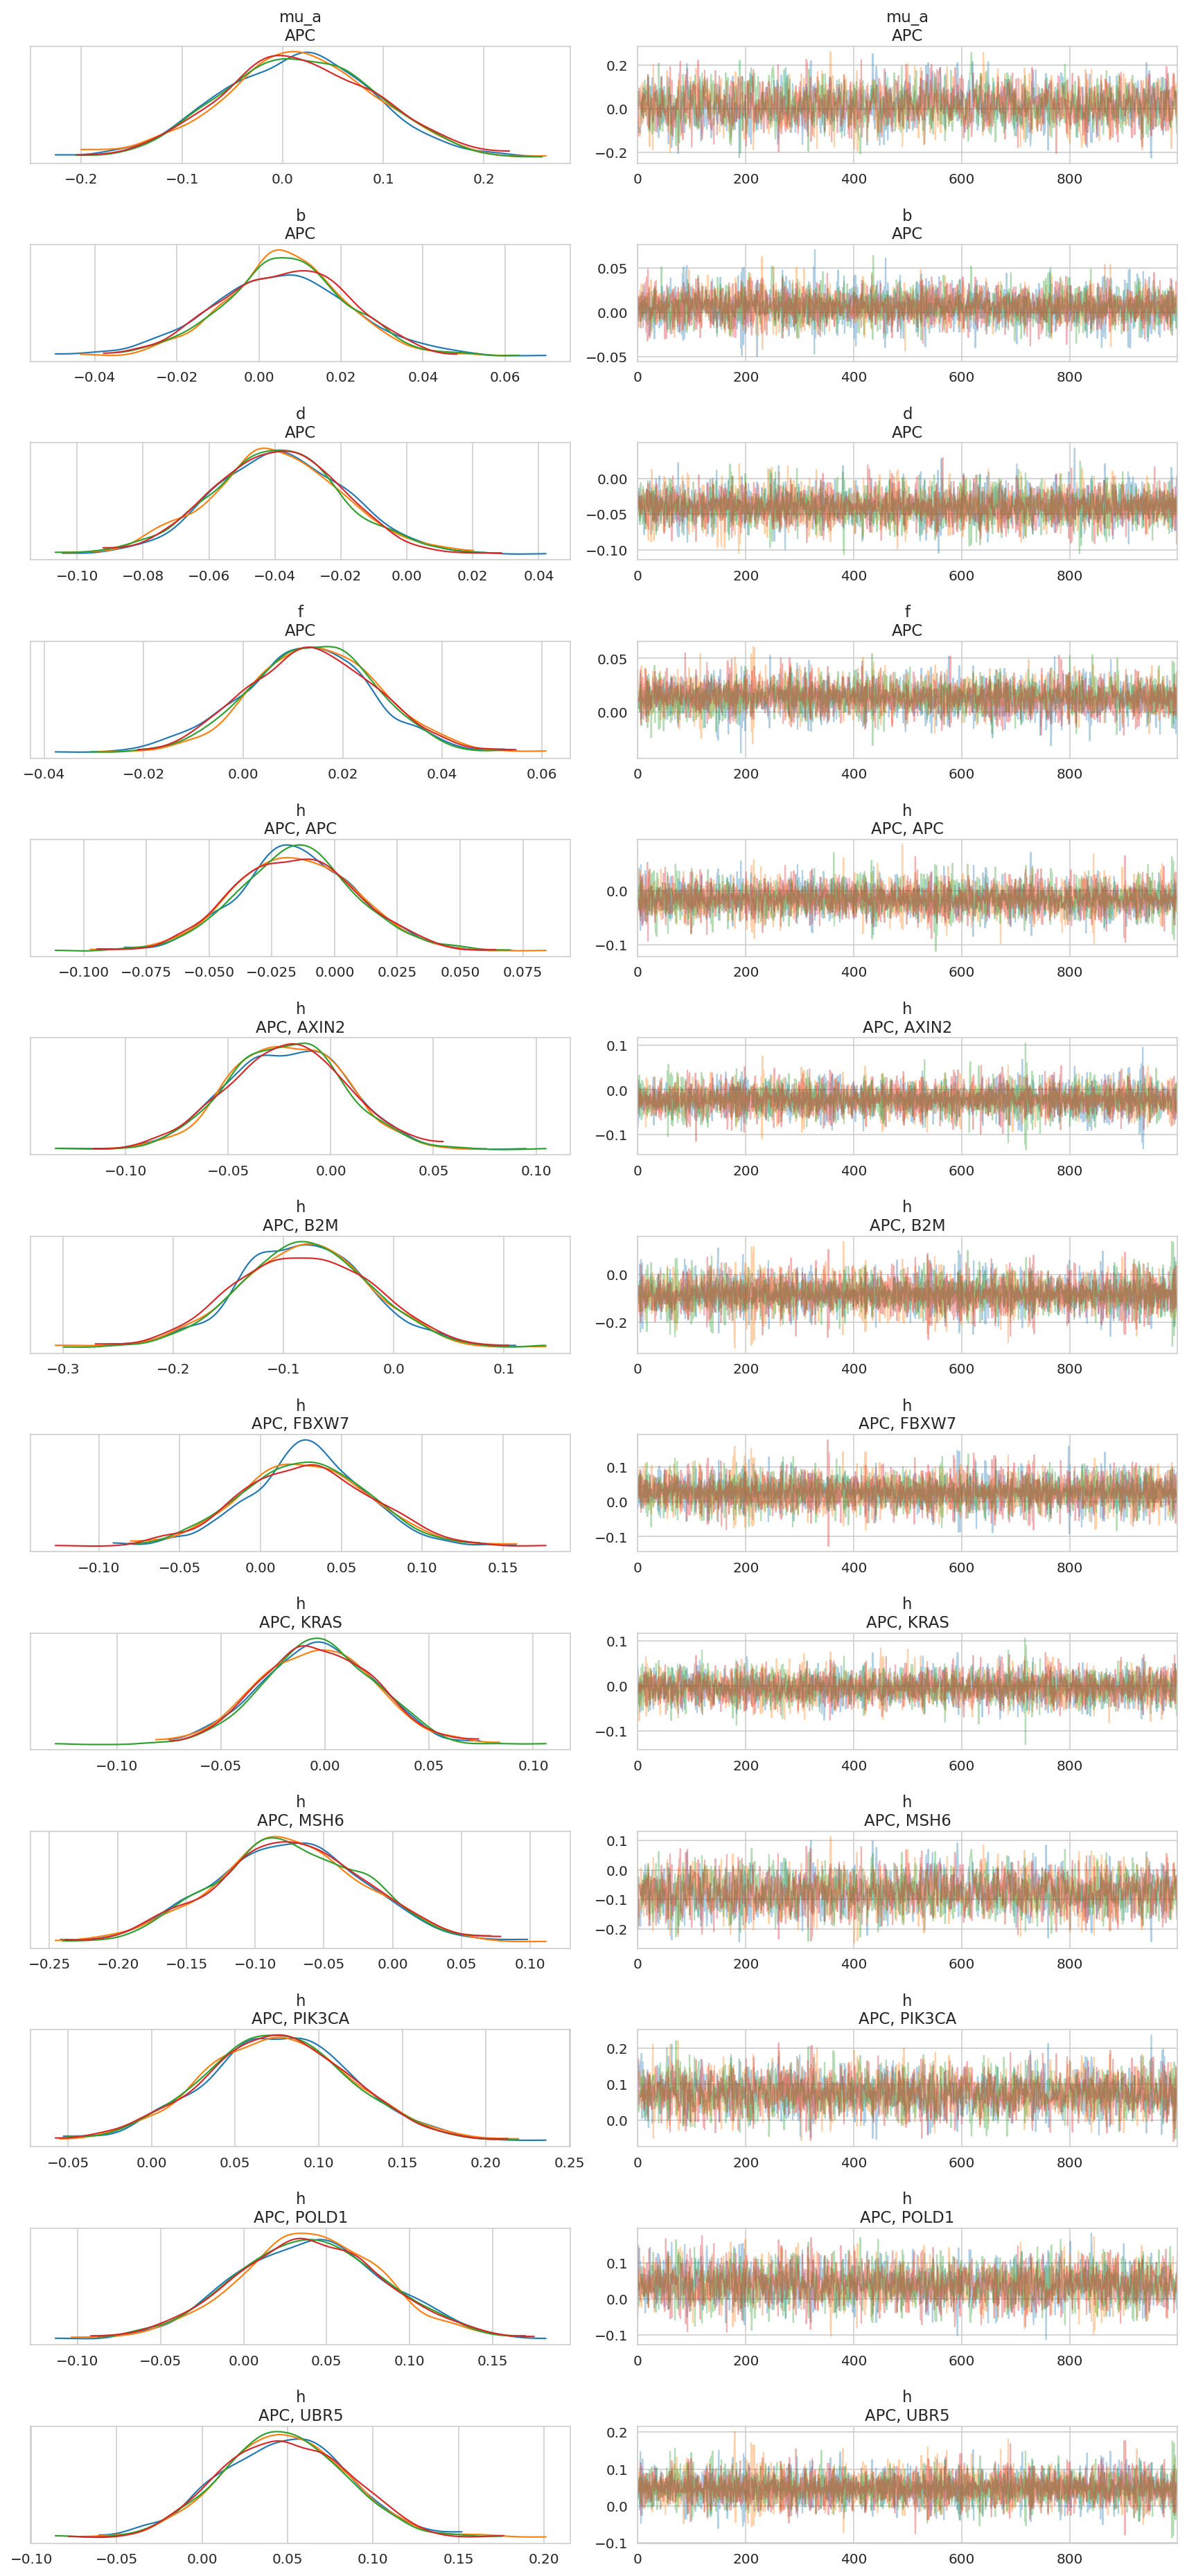

In [33]:
example_genes = ["KRAS", "APC"]
for gene in example_genes:
    _md_bold(gene)
    az.plot_trace(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        compact=False,
    )
    plt.tight_layout()
    plt.show()

**KRAS**

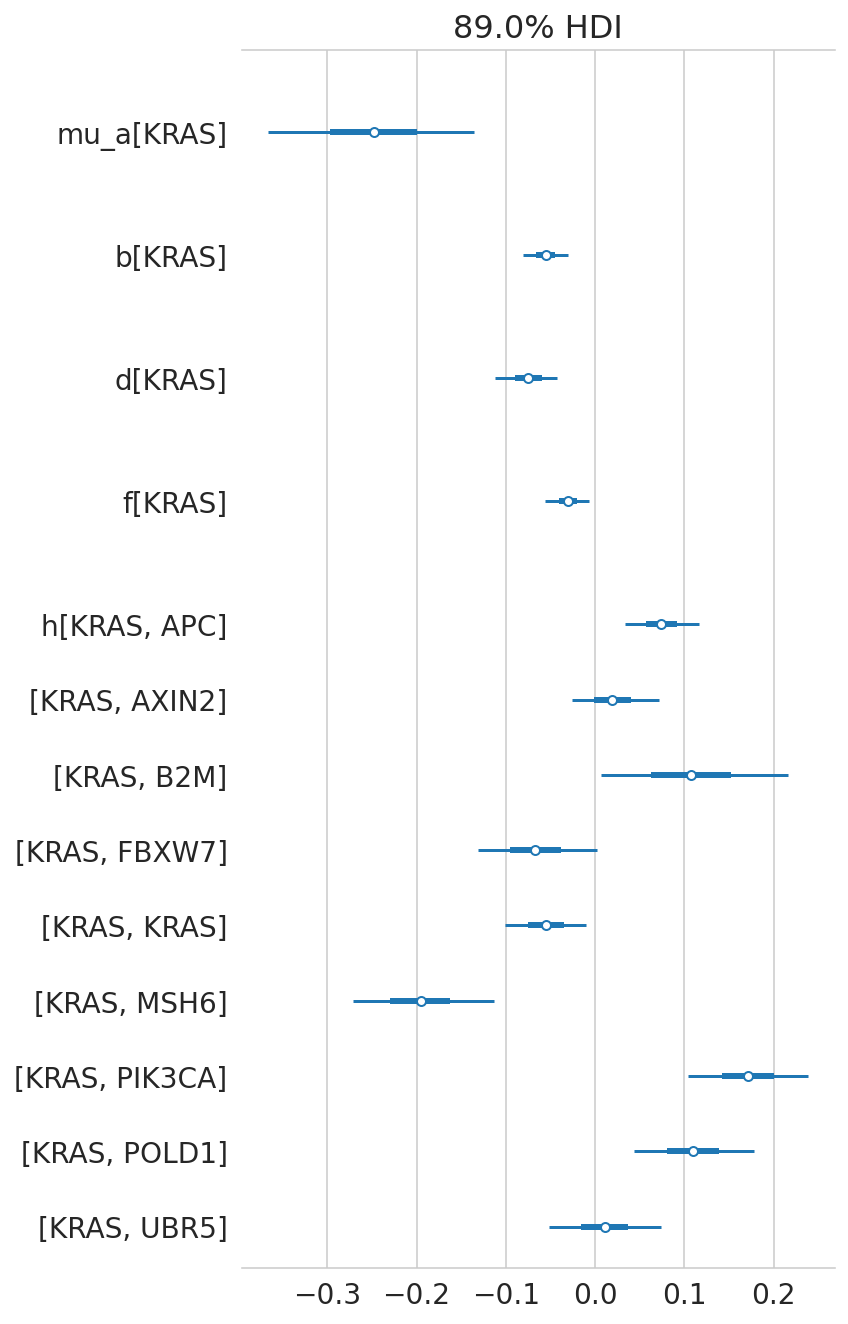

**APC**

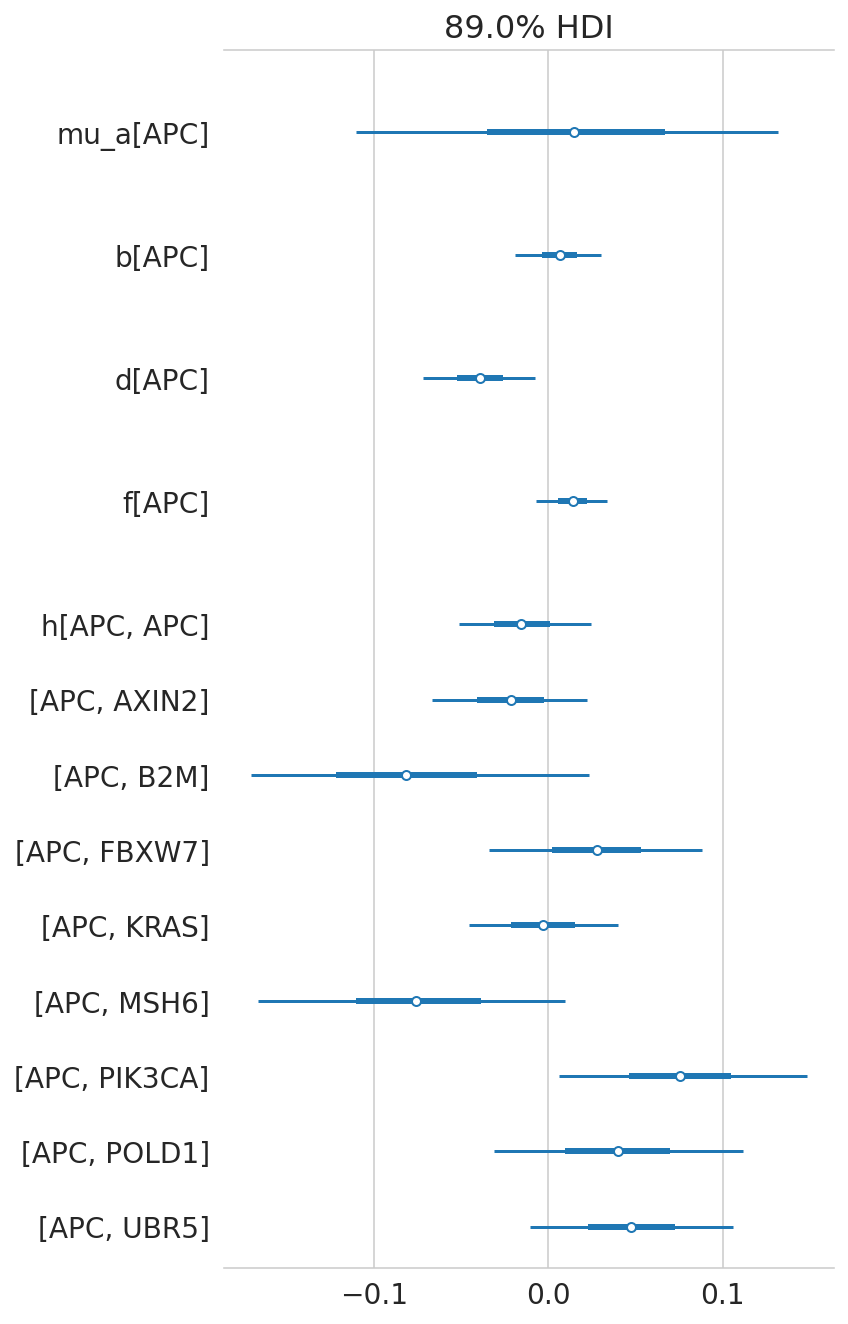

In [34]:
example_genes = ["KRAS", "APC"]
for gene in example_genes:
    _md_bold(gene)
    az.plot_forest(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        combined=True,
    )
    plt.tight_layout()
    plt.show()

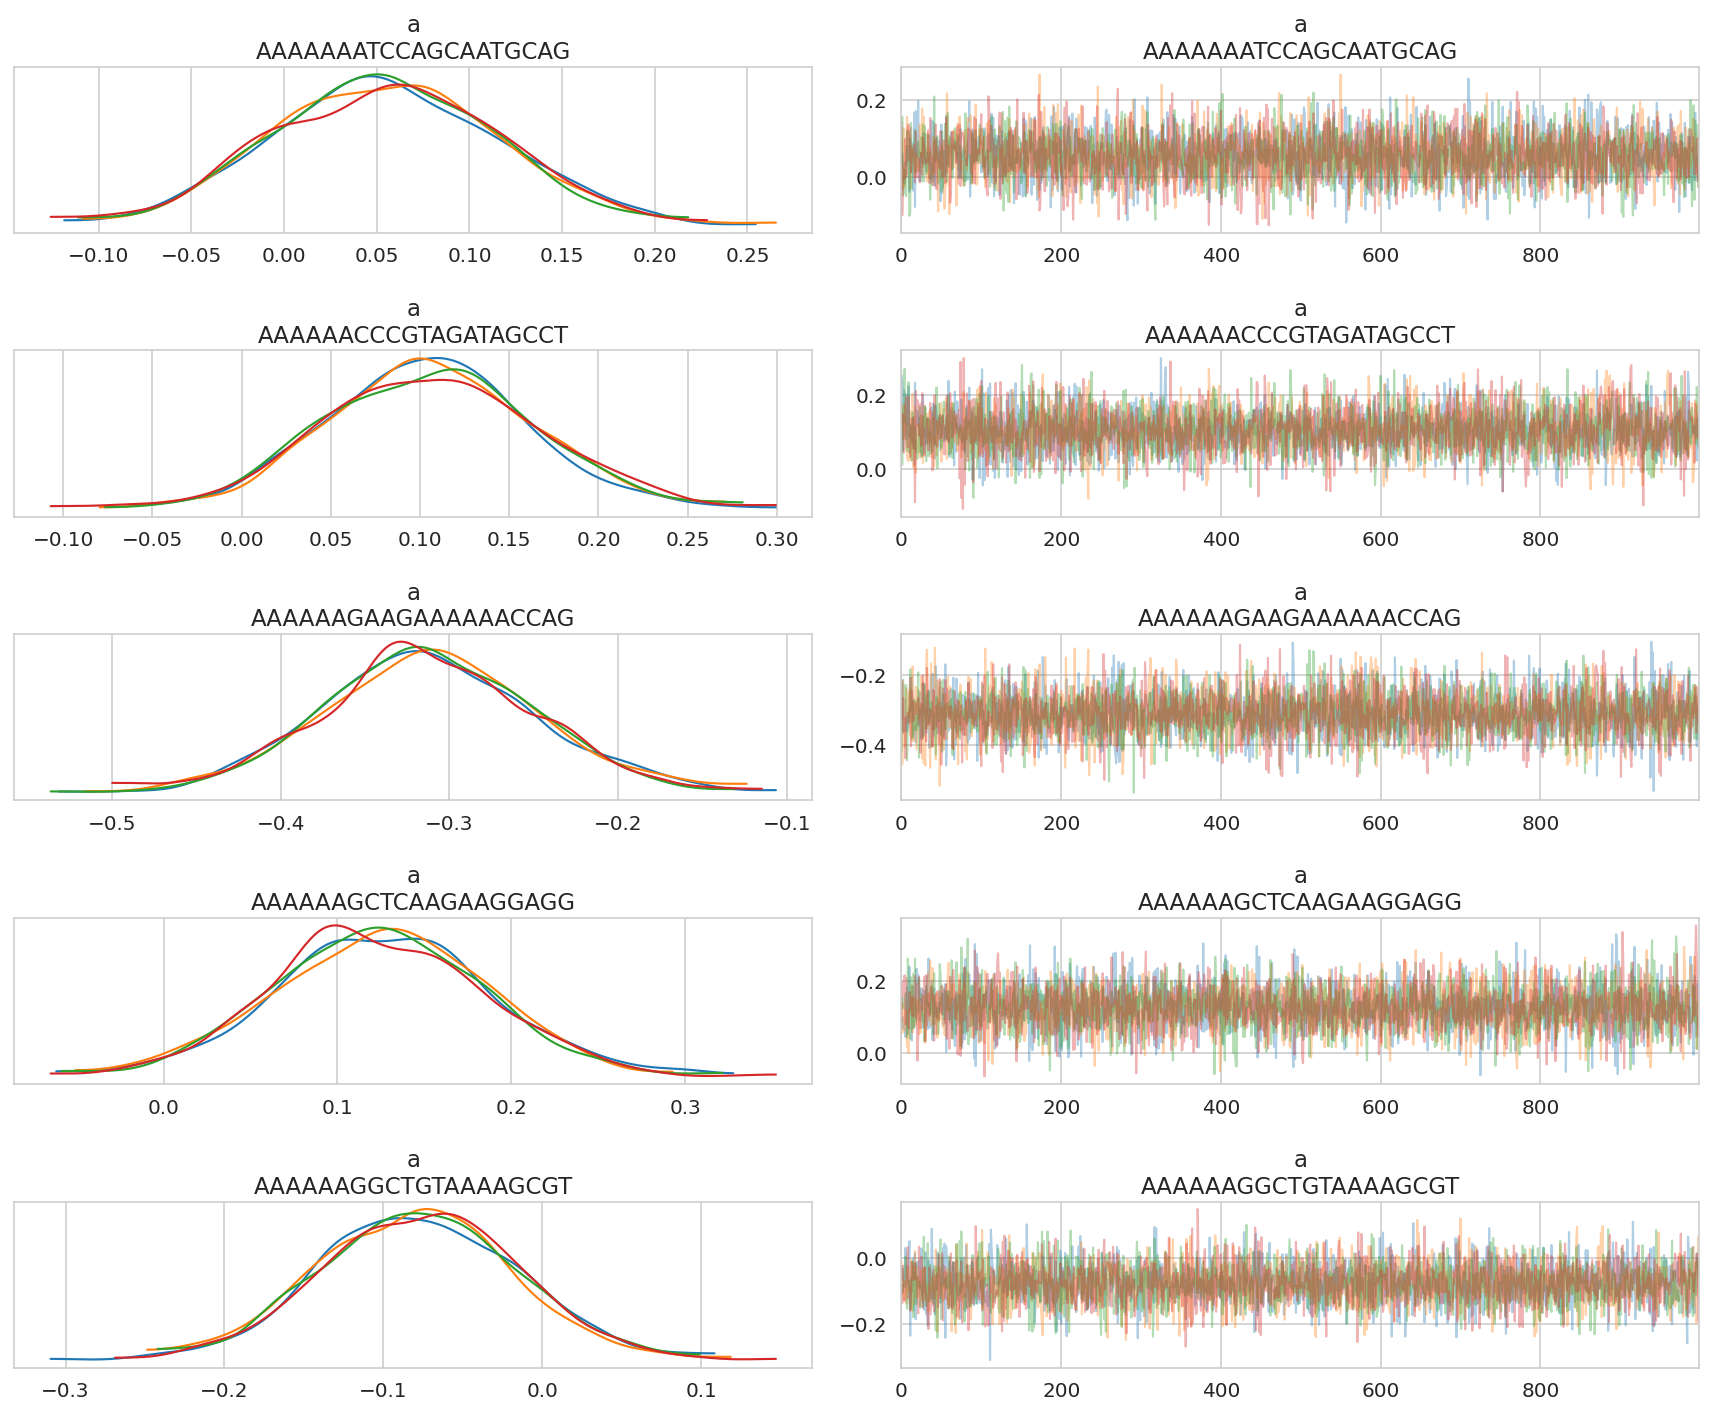

In [35]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

In [36]:
az.summary(trace, var_names="a", coords={"sgrna": sgrnas_sample})

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
a[AAAAAAATCCAGCAATGCAG]  0.054  0.061    -0.046      0.146      0.001   
a[AAAAAACCCGTAGATAGCCT]  0.105  0.059     0.016      0.201      0.001   
a[AAAAAAGAAGAAAAAACCAG] -0.312  0.063    -0.413     -0.211      0.001   
a[AAAAAAGCTCAAGAAGGAGG]  0.124  0.061     0.031      0.224      0.001   
a[AAAAAAGGCTGTAAAAGCGT] -0.078  0.061    -0.175      0.018      0.001   

                         mcse_sd  ess_bulk  ess_tail  r_hat  
a[AAAAAAATCCAGCAATGCAG]    0.001    6608.0    3466.0    1.0  
a[AAAAAACCCGTAGATAGCCT]    0.001    4887.0    2986.0    1.0  
a[AAAAAAGAAGAAAAAACCAG]    0.001    7356.0    3314.0    1.0  
a[AAAAAAGCTCAAGAAGGAGG]    0.001    5363.0    3289.0    1.0  
a[AAAAAAGGCTGTAAAAGCGT]    0.001    4864.0    2978.0    1.0

In [37]:
crc_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
3           sigma_a  0.182  0.001     0.181      0.183        0.0      0.0   
5        sigma_mu_a  0.204  0.001     0.202      0.207        0.0      0.0   
6           sigma_b  0.020  0.000     0.019      0.021        0.0      0.0   
7           sigma_d  0.029  0.000     0.029      0.030        0.0      0.0   
8           sigma_f  0.015  0.002     0.012      0.018        0.0      0.0   
9      sigma_h[APC]  0.030  0.001     0.028      0.031        0.0      0.0   
10   sigma_h[AXIN2]  0.032  0.001     0.031      0.034        0.0      0.0   
11     sigma_h[B2M]  0.079  0.001     0.077      0.081        0.0      0.0   
12   sigma_h[FBXW7]  0.049  0.001     0.047      0.050        0.0      0.0   
13    sigma_h[KRAS]  0.048  0.001     0.047      0.049        0.0      0.0   
14    sigma_h[MSH6]  0.142  0.001     0.140      0.144        0.0      0.0   
15  sigma_h[PIK3CA]  0.107  0.001     0.105      0.108        0.0      0.0   
16   sigma_h[POLD1]  0.094  0.002     0.092      0.097        0.0      0.0   
17    sigma_h[UBR5]  0.047  0.002     0.044      0.050        0.0      0.0   

    ess_bulk  ess_tail  r_hat    var_name  
3     1168.0    2194.0   1.00     sigma_a  
5     1308.0    2271.0   1.00  sigma_mu_a  
6     1755.0    2824.0   1.00     sigma_b  
7     1472.0    2580.0   1.00     sigma_d  
8      493.0    2163.0   1.01     sigma_f  
9     1501.0    2552.0   1.00     sigma_h  
10    2096.0    3146.0   1.00     sigma_h  
11    1533.0    2644.0   1.00     sigma_h  
12    1851.0    3096.0   1.00     sigma_h  
13    1731.0    2370.0   1.00     sigma_h  
14    2087.0    3039.0   1.00     sigma_h  
15    2191.0    3228.0   1.00     sigma_h  
16    3197.0    2727.0   1.00     sigma_h  
17    2557.0    2971.0   1.00     sigma_h

In [38]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]    1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1]    0.508  0.016     0.484      0.535   0   1   
genes_chol_cov_corr[0, 2]   -0.371  0.012    -0.391     -0.352   0   2   
genes_chol_cov_corr[0, 3]   -0.237  0.076    -0.353     -0.114   0   3   
genes_chol_cov_corr[0, 4]   -0.331  0.022    -0.367     -0.296   0   4   
...                            ...    ...       ...        ...  ..  ..   
genes_chol_cov_corr[12, 8]  -0.427  0.038    -0.484     -0.365  12   8   
genes_chol_cov_corr[12, 9]  -0.339  0.032    -0.389     -0.289  12   9   
genes_chol_cov_corr[12, 10]  0.452  0.032     0.403      0.503  12  10   
genes_chol_cov_corr[12, 11]  0.176  0.041     0.110      0.239  12  11   
genes_chol_cov_corr[12, 12]  1.000  0.000     1.000      1.000  12  12   

                                  p1         p2  
genes_chol_cov_corr[0, 0]       mu_a       mu_a  
genes_chol_cov_corr[0, 1]       mu_a          b  
genes_chol_cov_corr[0, 2]       mu_a          d  
genes_chol_cov_corr[0, 3]       mu_a          f  
genes_chol_cov_corr[0, 4]       mu_a     h[APC]  
...                              ...        ...  
genes_chol_cov_corr[12, 8]   h[UBR5]    h[KRAS]  
genes_chol_cov_corr[12, 9]   h[UBR5]    h[MSH6]  
genes_chol_cov_corr[12, 10]  h[UBR5]  h[PIK3CA]  
genes_chol_cov_corr[12, 11]  h[UBR5]   h[POLD1]  
genes_chol_cov_corr[12, 12]  h[UBR5]    h[UBR5]  

[169 rows x 8 columns]

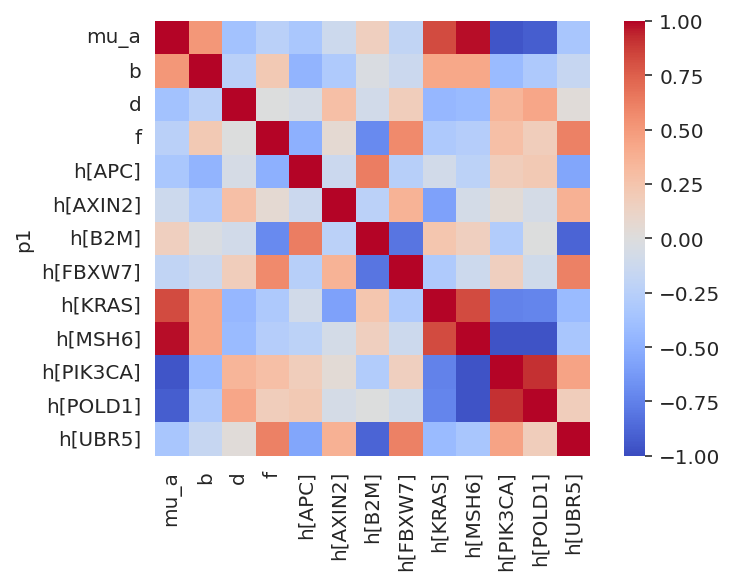

In [39]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.show()

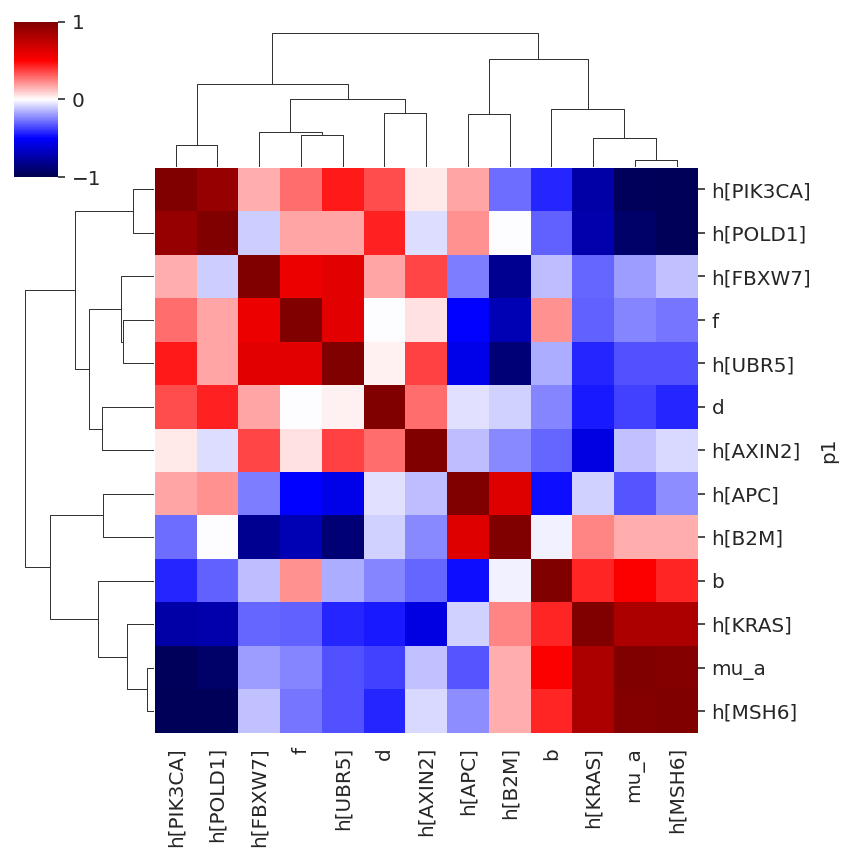

In [40]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.clustermap(plot_df, cmap="seismic", vmin=-1, vmax=1, figsize=(6, 6))
plt.show()

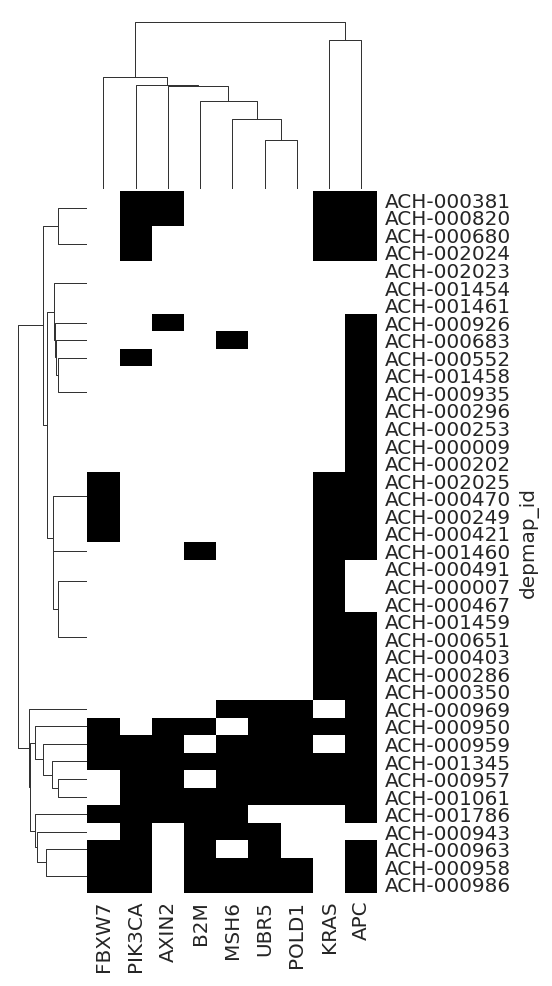

In [41]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_crc_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cg = sns.clustermap(
    cancer_gene_mutants, cmap="Greys", xticklabels=1, yticklabels=1, figsize=(4, 7)
)
cg.ax_heatmap.tick_params("both", length=0)
cg.ax_cbar.remove()
plt.show()

In [42]:
h_post_summary = (
    crc_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)
h_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0    h[A1BG, APC] -0.004  0.024    -0.042      0.036      0.000    0.000   
1  h[A1BG, AXIN2]  0.008  0.027    -0.033      0.053      0.000    0.000   
2    h[A1BG, B2M] -0.020  0.058    -0.113      0.070      0.001    0.001   
3  h[A1BG, FBXW7]  0.026  0.037    -0.035      0.084      0.000    0.001   
4   h[A1BG, KRAS]  0.013  0.025    -0.027      0.053      0.000    0.000   

   ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
0    8417.0    2974.0    1.0        h        A1BG         APC  
1    9075.0    2864.0    1.0        h        A1BG       AXIN2  
2   11295.0    2671.0    1.0        h        A1BG         B2M  
3   11959.0    2767.0    1.0        h        A1BG       FBXW7  
4    5381.0    3441.0    1.0        h        A1BG        KRAS

In [43]:
h_post_summary.sort_values("mean").pipe(head_tail, n=5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
113783       h[RAN, MSH6] -0.935  0.052    -1.019     -0.852      0.001   
38678     h[DONSON, MSH6] -0.855  0.053    -0.944     -0.772      0.001   
119741      h[RPSA, MSH6] -0.846  0.054    -0.938     -0.765      0.001   
110831     h[PSMD7, MSH6] -0.838  0.054    -0.921     -0.751      0.001   
106484    h[POLR2L, MSH6] -0.833  0.053    -0.915     -0.745      0.001   
38679   h[DONSON, PIK3CA]  0.624  0.045     0.556      0.700      0.001   
119742    h[RPSA, PIK3CA]  0.624  0.045     0.559      0.700      0.001   
110832   h[PSMD7, PIK3CA]  0.627  0.045     0.554      0.697      0.001   
106485  h[POLR2L, PIK3CA]  0.631  0.044     0.563      0.704      0.001   
113784     h[RAN, PIK3CA]  0.727  0.045     0.655      0.798      0.001   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
113783    0.001    2690.0    2749.0    1.0        h         RAN        MSH6  
38678     0.001    2946.0    3117.0    1.0        h      DONSON        MSH6  
119741    0.001    2618.0    2965.0    1.0        h        RPSA        MSH6  
110831    0.001    2952.0    3137.0    1.0        h       PSMD7        MSH6  
106484    0.001    2937.0    2991.0    1.0        h      POLR2L        MSH6  
38679     0.001    3509.0    3278.0    1.0        h      DONSON      PIK3CA  
119742    0.001    3784.0    3236.0    1.0        h        RPSA      PIK3CA  
110832    0.001    3773.0    3040.0    1.0        h       PSMD7      PIK3CA  
106485    0.000    3964.0    3424.0    1.0        h      POLR2L      PIK3CA  
113784    0.001    3450.0    3049.0    1.0        h         RAN      PIK3CA

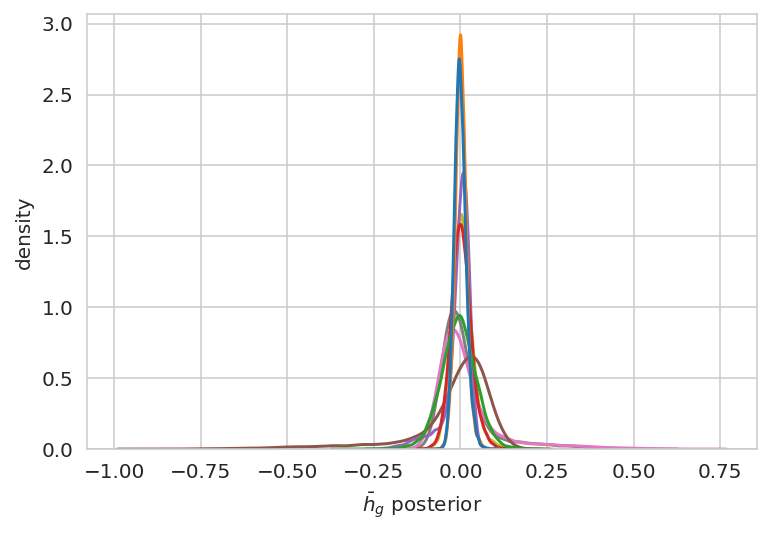

In [44]:
ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().remove()  # set_title("cancer gene\ncomut.")
plt.show()

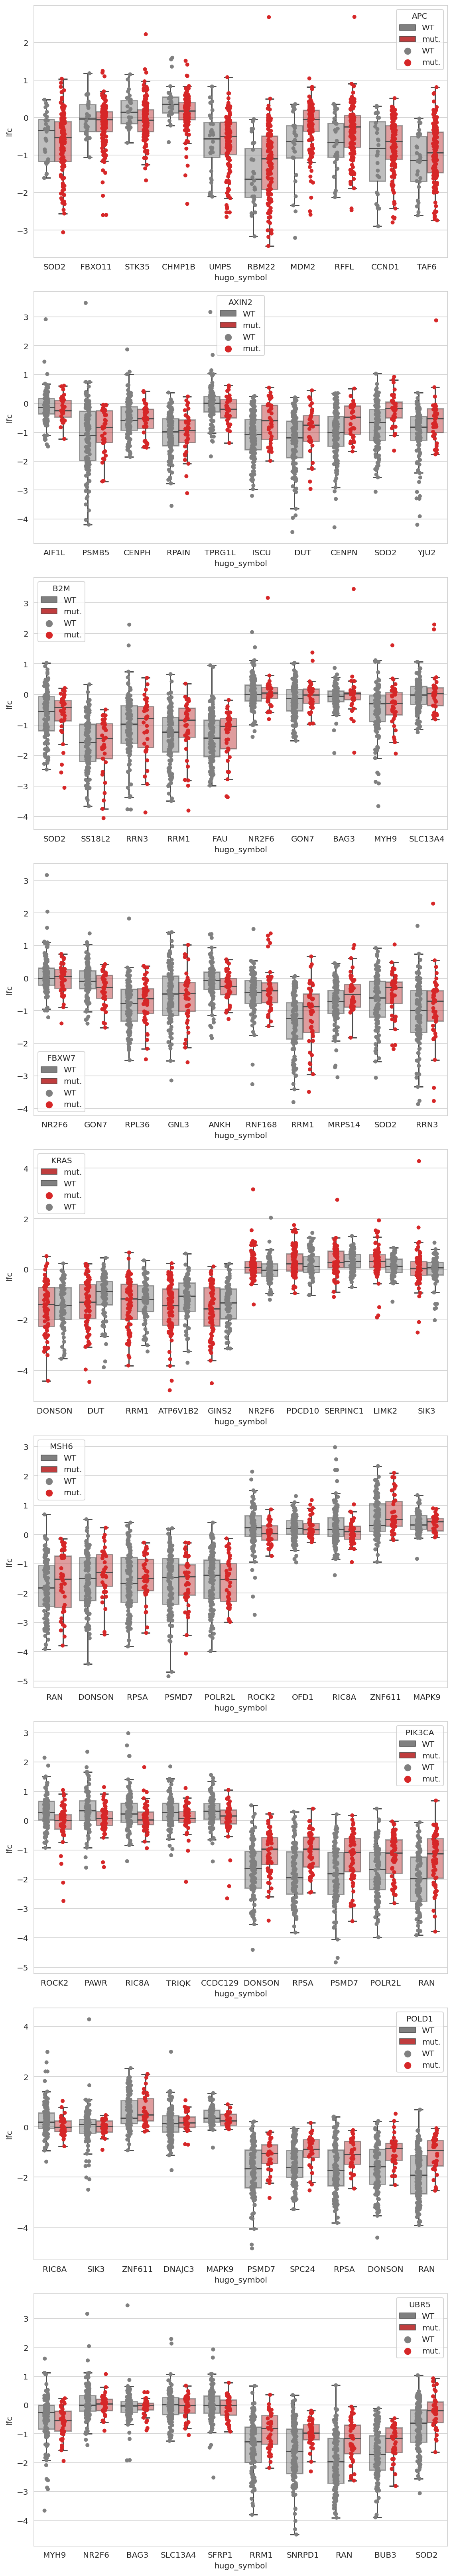

In [45]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_crc_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({True: "mut.", False: "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    ax.get_legend().set_title(cg)

plt.tight_layout()
plt.show()

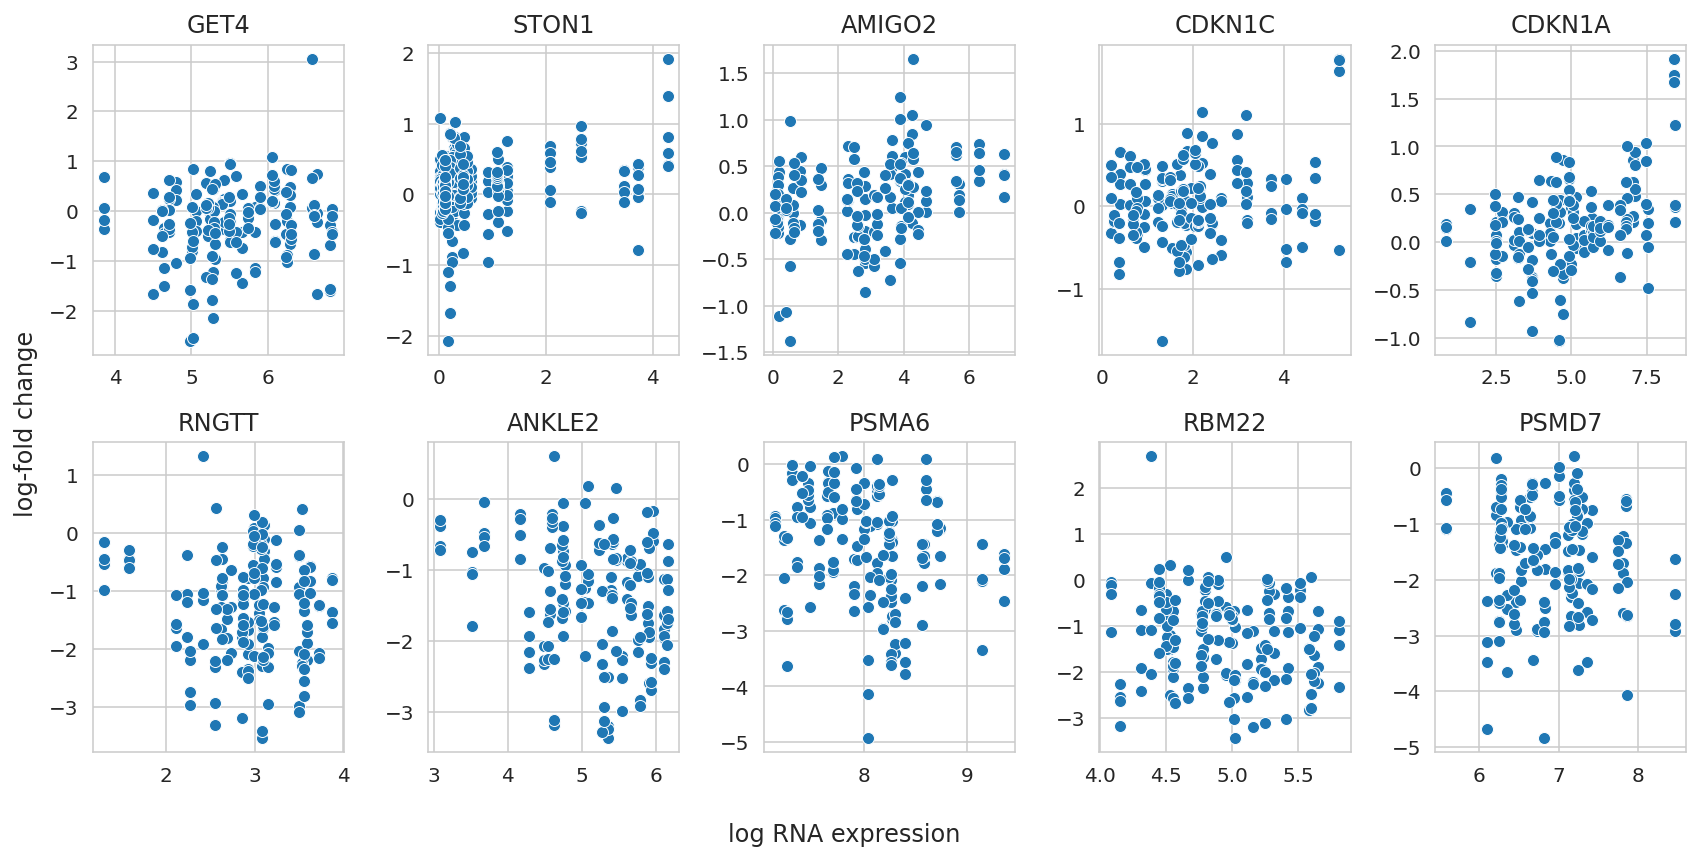

In [46]:
top_n = 5
top_b_hits = (
    crc_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = crc_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="rna_expr", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

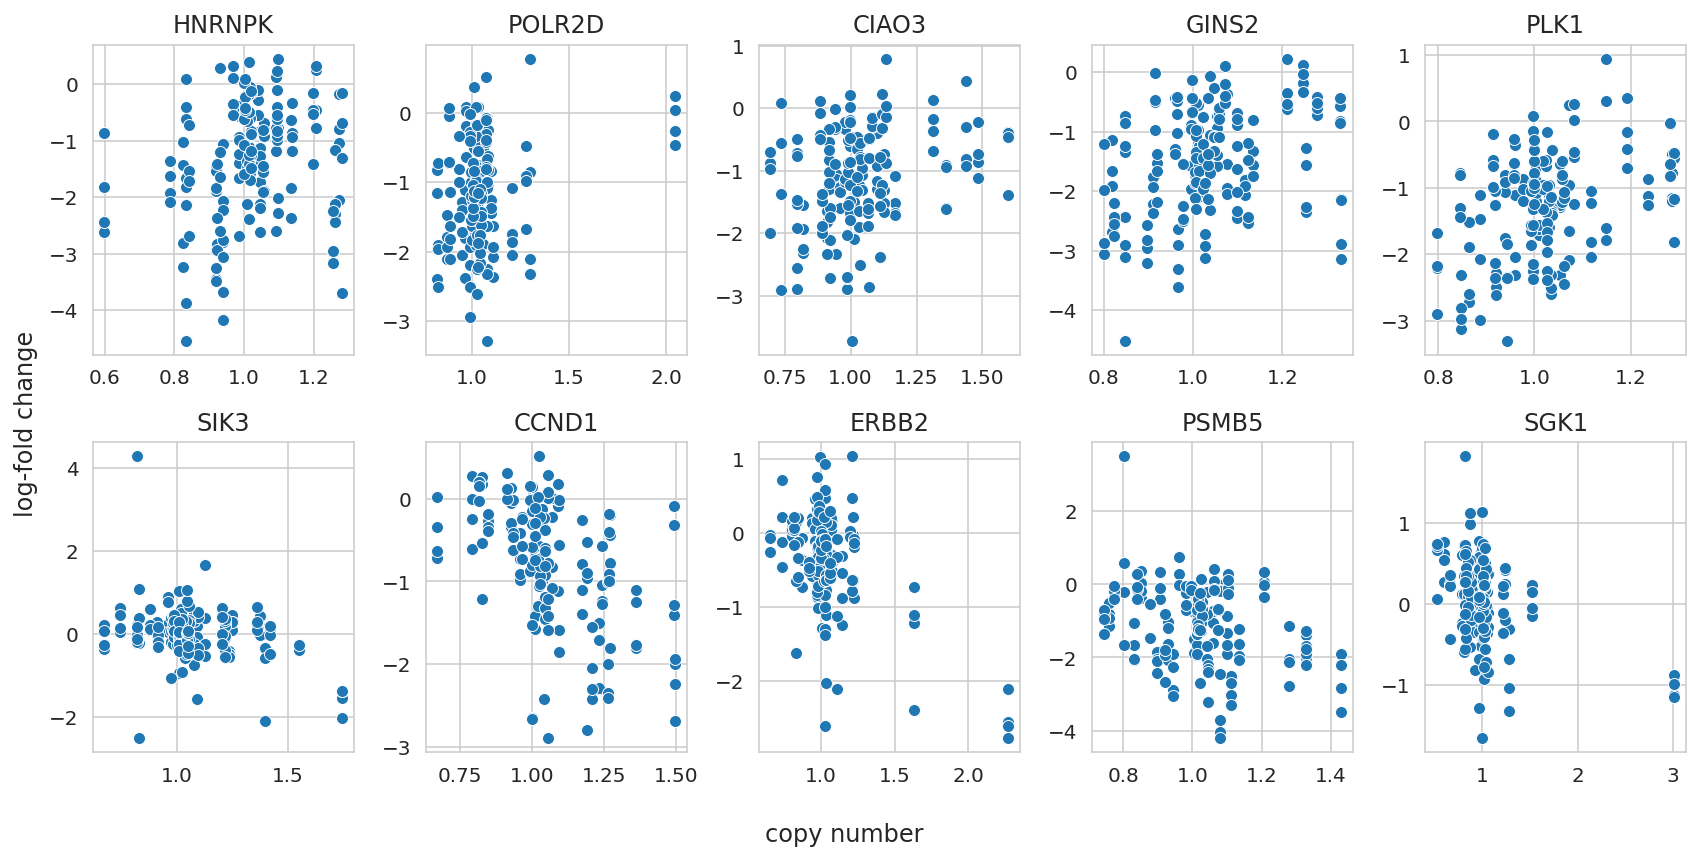

In [47]:
top_n = 5
top_d_hits = (
    crc_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = crc_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="copy_number", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## PPC

In [48]:
np.random.seed(99)
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 2842455)

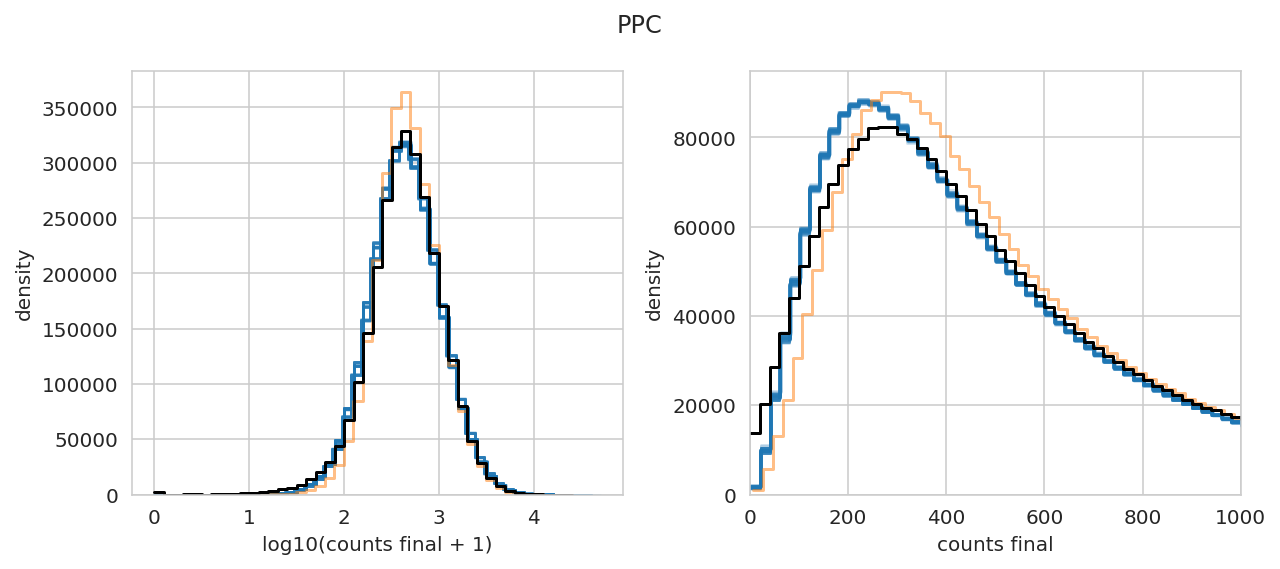

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]
hist_kwargs = {"stat": "count", "element": "step", "fill": False}

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

bw = 0.1
for i in range(example_ppc_draws.shape[0]):
    sns.histplot(
        x=np.log10(example_ppc_draws[i, :] + 1),
        alpha=0.2,
        binwidth=bw,
        color="tab:blue",
        ax=ax1,
        **hist_kwargs,
    )

sns.histplot(
    x=np.log10(pp_avg + 1),
    color="tab:orange",
    binwidth=bw,
    ax=ax1,
    alpha=0.5,
    **hist_kwargs,
)
sns.histplot(
    x=np.log10(valid_crc_data["counts_final"] + 1),
    color="k",
    binwidth=bw,
    ax=ax1,
    **hist_kwargs,
)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")

bw = 20
for i in range(example_ppc_draws.shape[0]):
    sns.histplot(
        x=example_ppc_draws[i, :],
        alpha=0.2,
        binwidth=bw,
        color="tab:blue",
        ax=ax2,
        **hist_kwargs,
    )

sns.histplot(
    x=pp_avg, color="tab:orange", alpha=0.5, ax=ax2, binwidth=bw, **hist_kwargs
)
sns.histplot(
    x=valid_crc_data["counts_final"], color="k", binwidth=bw, ax=ax2, **hist_kwargs
)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [50]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 17.87 minutes


In [51]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-03

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: simplify

pandas    : 1.4.3
seaborn   : 0.11.2
numpy     : 1.23.1
matplotlib: 3.5.2
arviz     : 0.12.1

